# EXAMEN FINAL

## Autor: Lucía Saiz Lapique

A continuación, importamos las librerías que serán utilizadas a lo largo del examen.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from tqdm import tqdm 
tqdm.pandas(desc="progress-bar")
import nltk, re, pprint
from nltk import tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import model_selection, naive_bayes, svm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

C:\Users\Luli\Documents\Anaconda\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


__1. Lea el contenido de ejemplo sobre un DataFrame__

In [2]:
datos = pd.read_csv('Noticias.csv')
datos.head()

,Text,Label
0,Aniversario del tiro más famoso en la historia...,Deportes
1,Así quiere terminar la NBA: en Disney Florida ...,Deportes
2,Illa asegura en que no había evidencia científ...,Nacional
3,La Guardia Civil envía a la juez las informaci...,Nacional
4,La Guardia Civil insinúa que Simón ocultó docu...,Nacional


In [3]:
len(datos)

16

__2. Realice las siguientes tareas de preprocesamiento: separación en tokens y a su voluntad extracción de raíces (stemming) u obtención de formas  normales. Imprima el resultado. Puede utilizar a su voluntad librerías NLTK o spaCy.__

Para el preprocesamiento a continuación, se decide utilizar la librería de nltk, pues en prácticas anteriores ambas librerías dieron resultados similares pero resulta más cómodo (en mi opinión) utilizar la de NLTK.

In [4]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('spanish')
a,b = 'áéíóúü','aeiouu' ## 
trans = str.maketrans(a,b)

In [5]:
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = doc.translate(trans)
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

Eliminamos del corpus las stopwords, las tildes de palabras que las contengan y las mayúsculas para que, en caso de que exista alguna palabra mal escrita o escrita de formas distintas en alguna frase, que el modelo las identifique como la misma. A continuación se puede observar el corpus normalizado:

In [6]:
norm_corpus = normalize_corpus(datos['Text'])
norm_corpus

array(['aniversario tiro mas famoso historia finales nba',
       'asi quiere terminar nba disney florida finales julio',
       'illa asegura habia evidencia cientifica prohibir m',
       'guardia civil envia juez informaciones abc irene montero m',
       'guardia civil insinua simon oculto documentacion juez m',
       'guardia civil zanja sanidad consciente riesgo virus enero',
       'nba desea volver julio', 'nba altavoz social politico unidos',
       'nba planea retomar temporada equipos luchando anillo',
       'nba volvera julio equipos concentrados disney world',
       'responsables area sanidad delegacion contradicen tesis guardia civil m',
       'investigadores insinuan aportar pruebas fernando simon oculta documentacion juez',
       'luz verde propietarios inicio nba julio orlando',
       'marlaska intenta zanjar crisis guardia civil nuevo jefe madrid perfil tecnico',
       'tres coroneles guardia civil rechazaron sustituir diego perez cobos',
       'vuelve nba cla

Lo introducimos en la base de datos original para trabajar con las frases tokenizadas más adelante.

In [7]:
datos['Tokens'] = norm_corpus
datos.reset_index(inplace = True)
datos.drop('index', inplace = True, axis = 1)
datos

,Text,Label,Tokens
0,Aniversario del tiro más famoso en la historia...,Deportes,aniversario tiro mas famoso historia finales nba
1,Así quiere terminar la NBA: en Disney Florida ...,Deportes,asi quiere terminar nba disney florida finales...
2,Illa asegura en que no había evidencia científ...,Nacional,illa asegura habia evidencia cientifica prohib...
3,La Guardia Civil envía a la juez las informaci...,Nacional,guardia civil envia juez informaciones abc ire...
4,La Guardia Civil insinúa que Simón ocultó docu...,Nacional,guardia civil insinua simon oculto documentaci...
5,La Guardia Civil zanja que Sanidad era conscie...,Nacional,guardia civil zanja sanidad consciente riesgo ...
6,La NBA desea volver el 31 de julio,Deportes,nba desea volver julio
7,La NBA es un altavoz social y político en Esta...,Deportes,nba altavoz social politico unidos
8,La NBA planea retomar la temporada con 22 equi...,Deportes,nba planea retomar temporada equipos luchando ...
9,La NBA volverá en julio con 22 equipos concent...,Deportes,nba volvera julio equipos concentrados disney ...


__3. Obtenga la matriz Bag-of-Words__

In [8]:
# Bag of words features en formato sparse
cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(norm_corpus)
cv_matrix

<16x88 sparse matrix of type '<class 'numpy.int64'>'
	with 117 stored elements in Compressed Sparse Row format>

In [9]:
# Representation densa
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [10]:
# Obtenemos el vocabulario (lista de palabras utilizadas)
vocab = cv.get_feature_names()
# Y vemos los vectores que representan cada documento
pd.DataFrame(cv_matrix, columns=vocab)

,abc,altavoz,anillo,aniversario,aportar,area,asegura,asi,cientifica,civil,...,tres,unidos,verde,virus,volver,volvera,vuelve,world,zanja,zanjar
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
8,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


__4. Obtenga e imprima la matriz TF-IDF__

In [11]:
tt = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True)
tt_matrix = tt.fit_transform(cv_matrix)

In [12]:
tt_matrix = tt_matrix.toarray()
vocab = cv.get_feature_names()
pd.DataFrame(np.round(tt_matrix, 2), columns=vocab)

,abc,altavoz,anillo,aniversario,aportar,area,asegura,asi,cientifica,civil,...,tres,unidos,verde,virus,volver,volvera,vuelve,world,zanja,zanjar
0,0.0,0.00,0.00,0.41,0.00,0.00,0.00,0.0,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.4,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
2,0.0,0.00,0.00,0.00,0.00,0.00,0.41,0.0,0.41,0.00,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
3,0.4,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.24,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
4,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.27,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
5,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.24,...,0.00,0.00,0.00,0.39,0.0,0.00,0.00,0.00,0.39,0.00
6,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,...,0.00,0.00,0.00,0.00,0.6,0.00,0.00,0.00,0.00,0.00
7,0.0,0.48,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,...,0.00,0.48,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
8,0.0,0.00,0.41,0.00,0.00,0.00,0.00,0.0,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
9,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.43,0.00,0.43,0.00,0.00


In [13]:
tv = TfidfVectorizer(min_df=0., max_df=1., norm='l2',
                     use_idf=True, smooth_idf=True)
tv_matrix = tv.fit_transform(norm_corpus)
tv_matrix = tv_matrix.toarray()

In [14]:
vocab = tv.get_feature_names()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)

,abc,altavoz,anillo,aniversario,aportar,area,asegura,asi,cientifica,civil,...,tres,unidos,verde,virus,volver,volvera,vuelve,world,zanja,zanjar
0,0.0,0.00,0.00,0.41,0.00,0.00,0.00,0.0,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.4,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
2,0.0,0.00,0.00,0.00,0.00,0.00,0.41,0.0,0.41,0.00,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
3,0.4,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.24,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
4,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.27,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
5,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.24,...,0.00,0.00,0.00,0.39,0.0,0.00,0.00,0.00,0.39,0.00
6,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,...,0.00,0.00,0.00,0.00,0.6,0.00,0.00,0.00,0.00,0.00
7,0.0,0.48,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,...,0.00,0.48,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
8,0.0,0.00,0.41,0.00,0.00,0.00,0.00,0.0,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
9,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.43,0.00,0.43,0.00,0.00


__5. Obtenga e imprima la matriz de similitud de documentos. Se recomienda que utilice la similitud coseno__

In [15]:
similarity_matrix = cosine_similarity(tv_matrix)
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.000000,0.167228,0.0,0.000000,0.000000,0.000000,0.066383,0.053486,0.045017,0.048063,0.000000,0.000000,0.046008,0.000000,0.000000,0.049289
1,0.167228,1.000000,0.0,0.000000,0.000000,0.000000,0.185088,0.052369,0.044077,0.265491,0.000000,0.000000,0.128278,0.000000,0.000000,0.048260
2,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.0,1.000000,0.240080,0.112804,0.000000,0.000000,0.000000,0.000000,0.112804,0.084680,0.000000,0.093265,0.103339,0.000000
4,0.000000,0.000000,0.0,0.240080,1.000000,0.128914,0.000000,0.000000,0.000000,0.000000,0.128914,0.338506,0.000000,0.106584,0.118097,0.000000
5,0.000000,0.000000,0.0,0.112804,0.128914,1.000000,0.000000,0.000000,0.000000,0.000000,0.228504,0.000000,0.000000,0.092171,0.102127,0.000000
6,0.066383,0.185088,0.0,0.000000,0.000000,0.000000,1.000000,0.078872,0.066383,0.201826,0.000000,0.000000,0.193195,0.000000,0.000000,0.072683
7,0.053486,0.052369,0.0,0.000000,0.000000,0.000000,0.078872,1.000000,0.053486,0.057105,0.000000,0.000000,0.054663,0.000000,0.000000,0.058562
8,0.045017,0.044077,0.0,0.000000,0.000000,0.000000,0.066383,0.053486,1.000000,0.182350,0.000000,0.000000,0.046008,0.000000,0.000000,0.049289
9,0.048063,0.265491,0.0,0.000000,0.000000,0.000000,0.201826,0.057105,0.182350,1.000000,0.000000,0.000000,0.139878,0.000000,0.000000,0.052624


__6. Realice una clusterización de los documentos por similitud. Utilice la matriz obtenida en el paso anterior y agrupe los documentos utilizando la varianza mínima de Ward. Represente el dendograma correspondiente. Imprima en formato tabla los documentos y la etiiqueta del clúster correspondiente. Se recomienda utilizar un valor por la distancia máxima de 2.0.__

In [16]:
Z = linkage(similarity_matrix, 'ward')
pd.DataFrame(Z, columns=['Cluster 1', 'Cluster 2', 'Distancia', 'Tamaño Cluster'], dtype='object')

,Cluster 1,Cluster 2,Distancia,Tamaño Cluster
0,4,11,0.978694,2
1,1,9,1.05489,2
2,5,10,1.09106,2
3,6,12,1.14492,2
4,3,14,1.27685,2
5,17,19,1.28265,4
6,13,15,1.2846,2
7,0,7,1.34367,2
8,18,20,1.35106,4
9,8,23,1.35705,3


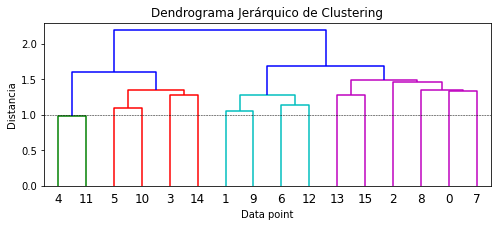

In [17]:
plt.figure(figsize=(8, 3))
plt.title('Dendrograma Jerárquico de Clustering')
plt.xlabel('Data point')
plt.ylabel('Distancia')
dendrogram(Z)
plt.axhline(y = 1.0, c = 'k', ls = '--', lw = 0.5)

Seleccionamos una distancia máxima entre clústeres de 2, como indica el enunciado, así que se elimina el último dato, dode la distancia euclídea era de 2,19.

In [18]:
max_dist = 2.0

In [19]:
cluster_labels = fcluster(Z, max_dist, criterion='distance')
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([datos, cluster_labels], axis=1)

,Text,Label,Tokens,ClusterLabel
0,Aniversario del tiro más famoso en la historia...,Deportes,aniversario tiro mas famoso historia finales nba,2
1,Así quiere terminar la NBA: en Disney Florida ...,Deportes,asi quiere terminar nba disney florida finales...,2
2,Illa asegura en que no había evidencia científ...,Nacional,illa asegura habia evidencia cientifica prohib...,2
3,La Guardia Civil envía a la juez las informaci...,Nacional,guardia civil envia juez informaciones abc ire...,1
4,La Guardia Civil insinúa que Simón ocultó docu...,Nacional,guardia civil insinua simon oculto documentaci...,1
5,La Guardia Civil zanja que Sanidad era conscie...,Nacional,guardia civil zanja sanidad consciente riesgo ...,1
6,La NBA desea volver el 31 de julio,Deportes,nba desea volver julio,2
7,La NBA es un altavoz social y político en Esta...,Deportes,nba altavoz social politico unidos,2
8,La NBA planea retomar la temporada con 22 equi...,Deportes,nba planea retomar temporada equipos luchando ...,2
9,La NBA volverá en julio con 22 equipos concent...,Deportes,nba volvera julio equipos concentrados disney ...,2


__7. Por último, a partir de la matriz TF-IDF obtenida en el paso 4, realice una clasificación utilizando el algoritmo Naive Bayesiano, y obtenga la matriz de confusión correspondiente__

Para realizar un modelo de clasficación y valorar los resultados obtenidos, lo primero que se debe hacer (previo a la matriz TF-IDF) es dividir los datos que deseamos estudiar en train y test, para poder estudiar la precisión y la matriz de confusión del modelo. Seleccionamos una muestra de test de 0,25 ya que este número influirá en la precisión y no contamos con una base de datos muy grande (solo 16 ejemplos).

In [51]:
# División en conjunto de entrenamiento y test

Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(datos['Tokens'], datos['Label'], test_size = 0.25)

In [52]:
# Codificación de etiquetas (categorías)
# Las categorías tienen una etiqueta tipo string, pero los algoritmos de clasifiación necesitan un valor numérico

Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

A continuación, generamos de nuevo la matriz TF-IDF con los datos de train.

In [53]:
# Vectorización: consitución de matrices tf-idf a partir de los subconjuntos de entrenamiento y test

Tfidf_vect = TfidfVectorizer(analyzer = lambda x: x, min_df = 1)
Tfidf_vect.fit(datos['Tokens'])

TfidfVectorizer(analyzer=<function <lambda> at 0x0000022FE686EDC8>,
                binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [54]:
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [55]:
Train_X_Tfidf

<12x26 sparse matrix of type '<class 'numpy.float64'>'
	with 211 stored elements in Compressed Sparse Row format>

### Modelo Bayesiano

In [56]:
# Algoritmo - Naive Bayes
# Se añade al clasificador el subconjunto de entrenamiento
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf, Train_Y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [57]:
# Se generan las predicciones
predictions_NB = Naive.predict(Test_X_Tfidf)

# Y se obtiene la precisión del modelo 
print("Naive Bayes Accuracy Score -> ", accuracy_score(predictions_NB, Test_Y) * 100)
print("Naive Bayes Confusion Matrix:")
print(confusion_matrix(Test_Y, predictions_NB))

Naive Bayes Accuracy Score ->  25.0
Naive Bayes Confusion Matrix:
[[1 0]
 [3 0]]


Observamos que este modelo devuelve una precisión del 25% pero solo se ha podido comprobar con 4 ejemplos, como vemos en la matriz de confusión (3 falsos negativos y un verdadero positivo). Al haber tan pocos datos, es difícil entrenar un modelo como este). Para mejorar esta precisión y el modelo, habría que aumentar el volumen del corpus original. Además, es muy poco preciso y, cada vez que se reinicia y se vuelve a ejecutar el notebook o si cambiamos la muestra de test, este accuracy cambia por completo (cuanto mayor el test, peor el accuracy, porque pierde muchos datos de entrenamimento).